# Feature Meanings and Predication for Used Car Auction Prices 

In [ ]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,accuracy_score
from sklearn.ensemble import RandomForestRegressor
import optuna
import lightgbm as lgb  

In [ ]:
df = pd.read_csv('datasets/project_car_prices.csv',error_bad_lines=False,warn_bad_lines=True)

In [ ]:
df.head(3)

## Meaning of Special Features

Most of the features are easy to understand, but there are some special.

### vin: Vehicle identification number

The first special feature is `vin`. From `wikipedia`, `vin` means ***Vehicle identification number***.
> A vehicle identification number (VIN) (also called a chassis number or frame number) is a unique code, including a serial number, used by the automotive industry to identify individual motor vehicles, towed vehicles, motorcycles, scooters and mopeds, as defined in ISO 3779 (content and structure) and ISO 4030 (location and attachment).

>  A `vin` has 17 letters. Components of `vin` are `World manufacturer identifier`(1-3),`Vehicle descriptor section`(4-9) and	`Vehicle identifier section`(10-17).

> Country or region codes can be distinguished by the first 2 letters of `World manufacturer identifier`.

> https://en.wikipedia.org/wiki/Vehicle_identification_number#Components

So we can **add a feature `made_country` with the first 2 letters of `vin`**.


We can check the info of a vin by https://driving-tests.org/vin-decoder/. If we query the first vin of the data `5xyktca69fg566472`,we can get a result like :

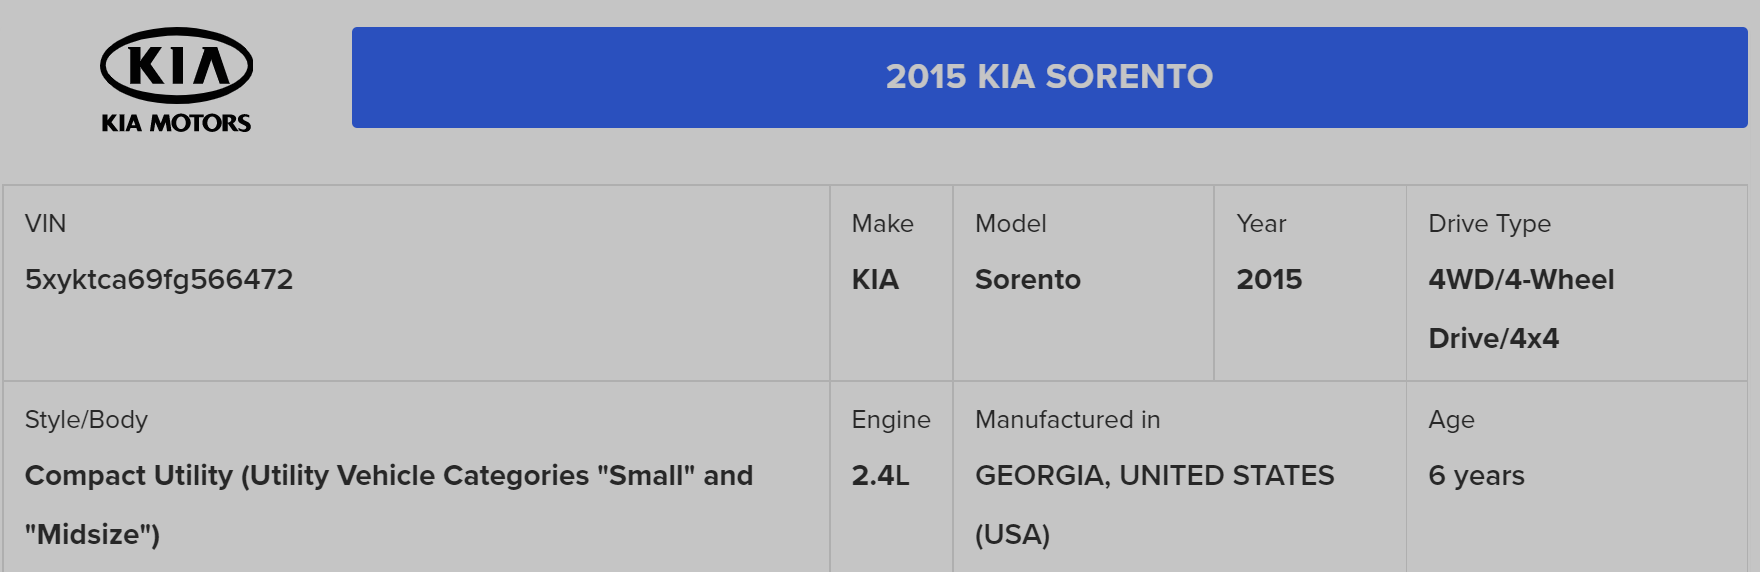

In [ ]:
df['made_country']=df['vin'].map(lambda x:x[:2])

### mmr: Manheim Market Report

In [ ]:
fig = px.scatter(df, x="mmr", y="sellingprice", title='Relation between mmr and sellingprice')
fig.show()

What really intersting is that `mmr` and `sellingprice` are so highly correlated. I did not find an explanation in `wikipedia`. But with Google I found this https://www.autoauctionmall.com/learning-center/what-does-mmr-mean/. 
> MMR in the car business stands for Manheim Market Report, an indicator of wholesale prices.

> Manheim is a company established in 1945 as a car auction company. It has grown to a very reputable company and its MMR is a baseline tool for wholesale car price determination. They base their price calculations on over 10 million transaction over the past 13-month period to .

I think that explained  why `mmr` and `sellingprice` are so close to each other in the figure. `mmr` is a valuation made by the Manheim company.The company should make full use of all the infomation of car like `model`,`odometer` and so on.

So it is **not** a good idea to take `mmr` as a explanatory feature.

### odometer: measuring the distance traveled by a vehicle

In [ ]:
df['odometer'].mean()

In [ ]:
fig = px.histogram(df, x="odometer",nbins=50,title='Distribution of odometer')
fig.show()

`odometer` means:
> An odometer or odograph is an instrument used for measuring the distance traveled by a vehicle, such as a bicycle or car. The device may be electronic, mechanical, or a combination of the two (electromechanical). The noun derives from ancient Greek ὁδόμετρον, hodómetron, from ὁδός, hodós ("path" or "gateway") and μέτρον, métron ("measure"). Early forms of the odometer existed in the ancient Greco-Roman world as well as in ancient China. In countries using Imperial units or US customary units it is sometimes called a mileometer or milometer, the former name especially being prevalent in the United Kingdom and among members of the Commonwealth.
> https://en.wikipedia.org/wiki/Odometer

From the figure above,the unit of measurement may be `kilometers`. If that is true, the mean odometer of used cars is 68000 kilometers. And most of them are within 200000 kilometers.

### year: vehicle's model year

After checking several vins, the `year` equals vehicle's model year.

In [ ]:
# change `mmr` to `valuation` and `year` to `model_year` for better understand
df=df.rename(columns={'mmr':'valuation','year':'model_year'})

##  Data Preparation

 overview of the data


In [ ]:
pd.DataFrame([df.isnull().mean(),df.dtypes,df.nunique()],index=['null_per','dtypes','nuique'])\
    .sort_values(by=['null_per'],axis=1,ascending=False)

handle missing values, drop them all since the the ratio is not high.


In [ ]:
df=df.dropna(axis=0)

data extract


In [ ]:
# extract `made_country` from vin
df['made_country']=df['vin'].map(lambda x:x[:2])

In [ ]:
# extract selling date info
df['sale_datetime'] = pd.to_datetime(df['saledate'],utc=True)


In [ ]:
df['sale_year']=df['sale_datetime'].dt.year.astype('int32')
df['sale_quarter']=df['sale_datetime'].dt.quarter.astype('int8')
df['sale_month']=df['sale_datetime'].dt.month.astype('int8')
df['sale_dayofweek']=df['sale_datetime'].dt.day_of_week.astype('int8')
df['sale_day']=df['sale_datetime'].dt.day.astype('int8')
df['sale_hour']= df['sale_datetime'].dt.hour.astype('int8')

In [ ]:
# clean body
df['xbody']=df['body'].map(lambda x:str(x).lower())

In [ ]:
pd.DataFrame([df.isnull().mean(),df.dtypes,df.nunique()],index=['null_per','dtypes','nuique'])\
    .sort_values(by=['null_per'],axis=1,ascending=False)

In [ ]:
# compress data
df['mode_year']= df['model_year'].astype('int32')

## How do we access the value of a car without valuations by specilists?

In [ ]:
heatmap_col=['sellingprice','model_year','condition','odometer','valuation','sale_year']
sns.set(rc={'figure.figsize':(7,7)})
sns.heatmap(df[heatmap_col].corr(), annot=True, fmt=".2f");

In [ ]:
pd.DataFrame([df.isnull().mean(),df.dtypes,df.nunique()],index=['null_per','dtypes','nuique'])\
    .sort_values(by=['nuique'],axis=1,ascending=True).T

In [ ]:
# choose features and filter `valuation` out
choosed_cols = ['model_year','condition','odometer','sellingprice',
                'make','model','trim','transmission','state','color','interior',
                'sale_dayofweek','sale_month','made_country','xbody']

In [ ]:
ff=df[choosed_cols].copy()

In [ ]:
# One-Hot Encode 
cat_cols = ff.select_dtypes(include=['object']).columns
ff_1 = pd.get_dummies(ff[cat_cols],dummy_na=False,prefix_sep='_',drop_first=True)
ff_2 = ff.drop(cat_cols,axis=1)

gf = ff_1.merge(ff_2,left_index=True,right_index=True)

In [ ]:
X_df = gf.drop(['sellingprice'],axis=1)
y_df = gf['sellingprice']


In [ ]:
def objective(trial):
    data,target = X_df.values,y_df.values
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)
    param = {
        "n_estimators":trial.suggest_int("n_estimators",20,200,log=True),
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
    }
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    score = r2_score(valid_y, pred_labels)
    return score


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
# one of the best params the optuna computed is 198
train_x, valid_x, train_y, valid_y = train_test_split(X_df.values, y_df.values,
                                                      test_size=0.25,random_state=100)
lgb_clf = lgb.LGBMRegressor(n_estimators=198)
lgb_clf.fit(train_x,train_y)
print(lgb_clf.score(valid_x,valid_y))


In [ ]:
#inspiration by https://www.kaggle.com/aleksandradeis/airbnb-seattle-reservation-prices-analysis#Machine-Learning
headers = ["name", "score"]
values = sorted(zip(X_df, lgb_clf.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:20]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:20]

#plot feature importances
plt.figure(figsize=(18,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('importances')
plt.xlabel('Features')
plt.title('Feature importances (LightGBM)') 
plt.show()

## Conclusion

In this analysis we tried to understand what influences used car 's selling price. We delete `valuation` from explained features, since it is a evaluated feature by business company. Alternatively, we tried to use basic info of a car to do a predict. The model has a similar `r2_score` with `valuation` and suggested `model_year`,`odometer`,`condition`  are the 3 features contributes most to the model.

Hope the predication is helpful to people who want to sell their cars!